In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/eye_quality/processed.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/eye_quality/")
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pytorch-lightning timm torchinfo

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/eye_quality'

In [1]:
root_dir = '/home/tiurin/projects/ExampleProject/Temp/'

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/')

In [4]:
import dataset_utils

In [5]:
from torch.utils.data import Subset,DataLoader
from torchvision import transforms, utils
import torchvision
import torch

In [6]:
import os

In [7]:
import numpy as np

In [8]:
import pytorch_lightning as pl

In [9]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Global seed set to 42


In [10]:
train_set, val_set, class_weights = dataset_utils.get_dataset(train_percent=0.9, rotation_transform=True)

In [11]:
#train_set = Subset(train_set, torch.arange(100))
#val_set = Subset(val_set, torch.arange(100))

In [12]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True,
                               drop_last=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False,
                             drop_last=False, num_workers=8)

In [13]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:2")
print("Using device", device)

Using device cuda:2


In [14]:
import torchinfo

In [15]:
from torch import optim, nn
import timm
import torchmetrics

In [16]:
import torch.nn.functional as F

In [17]:
class STNet(nn.Module):
    def __init__(self):
        super(STNet, self).__init__()
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(5, stride=5),
            nn.ReLU(),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(5, stride=5),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3),
            nn.MaxPool2d(3, stride=3),
            nn.ReLU()
        )
        
        self.fc_loc = nn.Sequential(
            nn.Linear(160, 32),
            nn.ReLU(),
            nn.Linear(32, 3 * 2)
        )
        
        def _init_weights(m):
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.0)
        
        self.localization.apply(_init_weights)
        
        torch.nn.init.xavier_uniform_(self.fc_loc[0].weight)
        self.fc_loc[0].bias.data.fill_(0.0)
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x, mask=None):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1)
        theta = self.fc_loc(xs)
        if mask is not None:
            theta[mask==False] = torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float).to(device)
        theta = theta.view(x.shape[0], 2, 3)
        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid)

        return x

In [18]:
stn = STNet()

In [19]:
torchinfo.summary(stn, (32, 1, 400, 400))

/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
STNet                                    [32, 1, 400, 400]         --
├─Sequential: 1-1                        [32, 10, 4, 4]            --
│    └─Conv2d: 2-1                       [32, 8, 394, 394]         400
│    └─MaxPool2d: 2-2                    [32, 8, 78, 78]           --
│    └─ReLU: 2-3                         [32, 8, 78, 78]           --
│    └─Conv2d: 2-4                       [32, 10, 74, 74]          2,010
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
│    └─ReLU: 2-6                         [32, 10, 14, 14]          --
│    └─Conv2d: 2-7                       [32, 10, 12, 12]          910
│    └─MaxPool2d: 2-8                    [32, 10, 4, 4]            --
│    └─ReLU: 2-9                         [32, 10, 4, 4]            --
├─Sequential: 1-2                        [32, 6]                   --
│    └─Linear: 2-10                      [32, 32]                  5,152
│    └─

In [20]:
class EyeQualityModel(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        
        self.stn = STNet()
        
        self.net = timm.create_model('efficientnet_es', pretrained=True, in_chans=1)
        self.net.classifier = nn.Identity()
        self.classifier = nn.Linear(1280, 2)
        
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.classifier.bias.data.fill_(0.0)

        self.class_weights = class_weights
        self.example_input_array = train_set[0][1].unsqueeze(0)
        
    def forward(self, x, mask_use_for_stn=None):
        x = self.stn(x, mask_use_for_stn)
        x = self.net(x)
        x = self.classifier(x)
        return x
    
    def ordinal_regression(self, predictions, targets):
        modified_target = torch.zeros_like(predictions)
        for i, target in enumerate(targets):
            if target > 0:
                modified_target[i, 0:target] = 1
        loss = torch.nn.functional.binary_cross_entropy_with_logits(predictions,
                                                                    modified_target,
                                                                    reduction='none').sum(dim=1)
        if self.class_weights is not None:
            for i, target in enumerate(targets):
                loss[i] *= self.class_weights[target]
        return loss
    
    def predict(self, img):
        x = self.forward(img)
        c = self.prediction2label(x)
        return c

    def prediction2label(self, pred: np.ndarray):
        pred = torch.sigmoid(pred)
        return torch.clamp((pred > 0.5).cumprod(axis=1).sum(axis=1), min=0)
    
    def training_step(self, batch, batch_idx):
        class_lbl, img = batch
        #mask_use_for_stn = class_lbl > 0
        mask_use_for_stn = None
        c = self.forward(img, mask_use_for_stn)
        loss = self.ordinal_regression(c, class_lbl)
        self.log("train_loss", loss.mean())
        return loss.mean()
    
    def validation_step(self, batch, batch_idx):
        class_lbl, img = batch
        c = self.forward(img)
        loss = self.ordinal_regression(c, class_lbl)
        self.log("val_loss", loss.mean())
        res = torch.vstack([self.prediction2label(c), class_lbl])
        return res
    
    def validation_epoch_end(self, validation_step_outputs):
        all_preds = torch.hstack(validation_step_outputs)
        acc = (all_preds[0,:] == all_preds[1,:]).sum()/all_preds.shape[-1]
        self.log("val_accuracy", acc)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        return [optimizer], [scheduler]

In [21]:
model = EyeQualityModel(class_weights)

In [22]:
class_weights

tensor([2.2797, 2.1154, 1.3084])

In [23]:
out = model(torch.zeros([1,1,400,400]))

In [24]:
out

tensor([[-0.0979,  0.1058]], grad_fn=<AddmmBackward0>)

In [25]:
torch.nn.functional.binary_cross_entropy_with_logits(out, torch.zeros([1,2]), reduction='none')

tensor([[0.6454, 0.7474]], grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [26]:
torchinfo.summary(model, (1, 1, 400, 400))

Layer (type:depth-idx)                             Output Shape              Param #
EyeQualityModel                                    [1, 2]                    --
├─STNet: 1-1                                       [1, 1, 400, 400]          --
│    └─Sequential: 2-1                             [1, 10, 4, 4]             --
│    │    └─Conv2d: 3-1                            [1, 8, 394, 394]          400
│    │    └─MaxPool2d: 3-2                         [1, 8, 78, 78]            --
│    │    └─ReLU: 3-3                              [1, 8, 78, 78]            --
│    │    └─Conv2d: 3-4                            [1, 10, 74, 74]           2,010
│    │    └─MaxPool2d: 3-5                         [1, 10, 14, 14]           --
│    │    └─ReLU: 3-6                              [1, 10, 14, 14]           --
│    │    └─Conv2d: 3-7                            [1, 10, 12, 12]           910
│    │    └─MaxPool2d: 3-8                         [1, 10, 4, 4]             --
│    │    └─ReLU: 3-9         

In [27]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

In [28]:
model = model.to(device)

In [ ]:
checkpoint_path = os.path.join(root_dir, 'training')
model_name = 'eyeq_model_init_uniform'
root_dir = os.path.join(checkpoint_path, model_name)

trainer = pl.Trainer(default_root_dir=root_dir,
    accelerator="gpu" if str(device).startswith("cuda") else "cpu",
    devices=[device.index],
    max_epochs=10,
    callbacks=[ModelCheckpoint(dirpath=root_dir, 
                filename=model_name+'-{epoch}-{val_accuracy:.2f}', 
                save_weights_only=True, 
                save_last=True),
                LearningRateMonitor("epoch")],
    check_val_every_n_epoch=1)

trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/tiurin/projects/ExampleProject/Temp/training/eyeq_model_init_uniform/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type         | Params | In sizes                | Out sizes       
-----------------------------------------------------------------------------------------
0 | stn        | STNet        | 8.7 K  | [[1, 1, 400, 400], '?'] | [1, 1, 400, 400]
1 | net        | EfficientNet | 4.2 M  | [1, 1, 400, 400]        | [1, 1280]       
2 | classifier | Linear       | 2.6 K  | [1, 1280]               | [1, 2]          
-----------------------------------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.672    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

In [82]:
s = val_set[1000]
s[0]

1

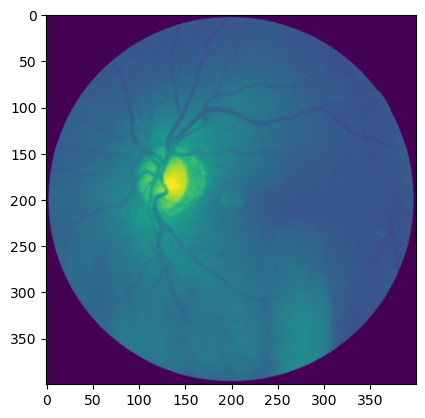

In [83]:
plt.imshow(dataset_utils.prepare_for_vis(s[1]))

In [84]:
model.forward(s[1].unsqueeze(0).to(device))

/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([[ 1.2861, -1.5921]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [69]:
torch.sigmoid)

tensor([[0.7835, 0.1691]], device='cuda:0', grad_fn=<SigmoidBackward0>)